<a href="https://colab.research.google.com/github/rahalsaabiumara/petpoint-py/blob/main/petpoint_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Instalasi Library yang Diperlukan**

In [1]:
!pip install tensorflow==2.11.0
!pip install tensorflow-addons
!pip install seqeval
!pip install sastrawi
!pip install nltk
!pip install scikit-learn
!pip install matplotlib
!pip install imbalanced-learn
!pip install tf2crf
!pip install ijson

**Import Library**

In [2]:
import json
import ijson
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Embedding, Bidirectional, LSTM, Dense,
    TimeDistributed, Dropout, LayerNormalization, SpatialDropout1D
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from seqeval.metrics import classification_report as seqeval_classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import nltk
import re
import warnings
import random
import matplotlib.pyplot as plt
from tf2crf import CRF, ModelWithCRFLoss

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.13.0 and strictly below 2.16.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.11.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're u

In [3]:
# Supress warnings untuk kebersihan output
warnings.filterwarnings('ignore')

In [4]:
# Download NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

**Memuat Dataset**

In [6]:
# Load NER dataset
with open('/content/ner_dataset.json', 'r', encoding='utf-8') as f:
    ner_data = json.load(f)

# Load Intent dataset
with open('/content/intent_dataset.json', 'r', encoding='utf-8') as f:
    intent_data = json.load(f)

**Inisialisasi Stemmer dan Stopwords**

In [7]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()
stopwords_indonesia = set(nltk.corpus.stopwords.words('indonesian'))
# Adjust the stopword list by excluding domain-specific words
custom_stopwords = stopwords_indonesia - {'anjing', 'kucing', 'sakit', 'gejala'}

In [8]:
# Load slang dictionary
with open('/content/combined_slang_words.txt', 'r', encoding='utf-8') as f:
    slang_dict = json.load(f)

**Mendefinisikan Fungsi Preprocessing**

Fungsi ini akan melakukan beberapa langkah preprocessing pada teks, termasuk lowercase, penghapusan URL, emoticon, punctuation, normalisasi slang, penghapusan stopwords, dan stemming.

In [9]:
# Preprocess function
def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Remove URLs, mentions, and hashtags
    text = re.sub(r'http\S+|www\S+|@\S+|#\S+', '', text)
    # Remove or handle emoticons
    text = re.sub(r'[:;]-?[)D]', '', text)  # Simplified emoticon removal
    # Remove punctuation and numbers, allowing Bahasa Indonesia characters
    text = re.sub(r'[^a-z\s]', '', text, flags=re.UNICODE)
    # Tokenize
    tokens = nltk.word_tokenize(text)
    # Normalize slang
    tokens = [slang_dict.get(token, token) for token in tokens]
    # Remove stopwords
    tokens = [word for word in tokens if word not in custom_stopwords]
    # Stemming
    tokens = [stemmer.stem(word) for word in tokens]
    return ' '.join(tokens)

**Ekstraksi Utterances dan Intents**

Mengiterasi setiap item dalam dataset Intent dan mengekstrak utterances serta intents.

In [10]:
# Extract utterances and intents
utterances = []
intents = []

# Iterate directly over the list of intent items
for intent_item in intent_data["intents"]:
    conditions = intent_item.get("conditions", [])
    if not conditions:
        continue  # Skip intents without conditions
    intent = conditions[0].lower()  # Gunakan lowercase untuk konsistensi
    for utterance in intent_item.get("text", []):  # Access the list of utterances
        preprocessed_utterance = preprocess_text(utterance)
        utterances.append(preprocessed_utterance)
        intents.append(intent)

**Encoding Intents**

Mengubah label intents menjadi format numerik menggunakan *LabelEncoder*

In [11]:
# Encode intents
label_encoder = LabelEncoder()
intent_labels = label_encoder.fit_transform(intents)
num_intent_classes = len(label_encoder.classes_)

**Persiapan Data NER**

Mengiterasi setiap item dalam dataset NER, memproses teks, dan memetakan entitas ke token yang telah diproses.

In [12]:
# Prepare texts and labels for NER
texts_ner = []
labels_ner = []

def align_tokens(original_tokens, preprocessed_tokens):
    alignment = []
    preprocessed_index = 0
    for orig_token in original_tokens:
        orig_token_processed = stemmer.stem(slang_dict.get(orig_token.lower(), orig_token.lower()))
        if preprocessed_index < len(preprocessed_tokens) and orig_token_processed == preprocessed_tokens[preprocessed_index]:
            alignment.append(preprocessed_index)
            preprocessed_index += 1
        else:
            alignment.append(None)
    return alignment

def align_predictions(pred_tags, alignment):
    aligned_tags = []
    for idx in alignment:
        if idx is not None and idx < len(pred_tags):
            aligned_tags.append(pred_tags[idx])
        else:
            aligned_tags.append('O')
    return aligned_tags

for item in ner_data:
    text = item['sentence']  # Perbaikan key dari 'text' menjadi 'sentence'
    entities = item['entities']
    # Preprocess text
    preprocessed_text = preprocess_text(text)
    texts_ner.append(preprocessed_text)
    # Tokenize preprocessed text
    tokens = nltk.word_tokenize(preprocessed_text)
    label_sequence = ['O'] * len(tokens)
    # Tokenize original text for alignment
    original_tokens = nltk.word_tokenize(text.lower())
    alignment = align_tokens(original_tokens, tokens)
    # Map entities to preprocessed tokens
    for entity in entities:
        start = entity['start']
        end = entity['end']
        label = entity['type'].lower()  # Pastikan konsistensi label
        entity_text = text[start:end].lower()
        entity_tokens = nltk.word_tokenize(entity_text)
        preprocessed_entity_tokens = [stemmer.stem(slang_dict.get(word, word)) for word in entity_tokens if word not in custom_stopwords]
        entity_length = len(preprocessed_entity_tokens)
        if entity_length == 0:
            continue  # Skip if entity_tokens setelah preprocessing kosong
        # Find the entity in tokens
        for i in range(len(tokens) - entity_length + 1):
            if tokens[i:i+entity_length] == preprocessed_entity_tokens:
                label_sequence[i] = 'B-' + label
                for j in range(1, entity_length):
                    label_sequence[i + j] = 'I-' + label
                break
    labels_ner.append(label_sequence)

**Membuat Vocabulary dan Tokenisasi**

Menggabungkan semua teks untuk membuat vocabulary, kemudian melakukan tokenisasi dan padding pada dataset Intent dan NER.

In [13]:
# Create a combined vocabulary
all_texts = utterances + texts_ner
tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(all_texts)
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1  # Add 1 for padding token

# Tokenize intent utterances
sequences_intent = tokenizer.texts_to_sequences(utterances)
# Tokenize NER texts
sequences_ner = tokenizer.texts_to_sequences(texts_ner)
# Determine max_len
max_len_intent = max(len(seq) for seq in sequences_intent) if sequences_intent else 0
max_len_ner = max(len(seq) for seq in sequences_ner) if sequences_ner else 0
max_len = max(max_len_intent, max_len_ner)
# Pad sequences to max_len
X_intent = pad_sequences(sequences_intent, maxlen=max_len, padding='post')
X_ner = pad_sequences(sequences_ner, maxlen=max_len, padding='post')

**Mendefinisikan Tag NER dan Mengubahnya Menjadi Indeks**

In [14]:
# Define NER tags
ner_tags = ['O']
entity_labels = ['animal', 'condition', 'symptom']

for label in entity_labels:
    ner_tags.append('B-' + label)
    ner_tags.append('I-' + label)

# Create tag to index mapping
tag2idx = {tag: idx for idx, tag in enumerate(ner_tags)}
idx2tag = {idx: tag for tag, idx in tag2idx.items()}
num_tags = len(tag2idx)

# Convert labels to indices
y_ner = []
for label_sequence in labels_ner:
    label_ids = [tag2idx.get(label, tag2idx['O']) for label in label_sequence]
    # Pad labels
    label_ids += [tag2idx['O']] * (max_len - len(label_ids))
    y_ner.append(label_ids)

y_ner = np.array(y_ner)

**Membagi Data Menjadi Training dan Testing**

Membagi dataset Intent dan NER menjadi data training dan testing dengan proporsi 80-20.

In [15]:
# Convert intent labels
y_intent = np.array(intent_labels)

# Split intent data
X_intent_train, X_intent_test, y_intent_train, y_intent_test = train_test_split(
    X_intent, y_intent, test_size=0.2, random_state=42, stratify=y_intent
)

# Split NER data and texts
X_ner_train, X_ner_test, y_ner_train, y_ner_test, texts_ner_train, texts_ner_test = train_test_split(
    X_ner, y_ner, texts_ner, test_size=0.2, random_state=42
)

# Optional: Print shapes to verify
print("Intent Data:")
print("Train:", X_intent_train.shape, y_intent_train.shape)
print("Test:", X_intent_test.shape, y_intent_test.shape)

print("\nNER Data:")
print("Train:", X_ner_train.shape, y_ner_train.shape)
print("Test:", X_ner_test.shape, y_ner_test.shape)

Intent Data:
Train: (1668, 21) (1668,)
Test: (418, 21) (418,)

NER Data:
Train: (1668, 21) (1668, 21)
Test: (418, 21) (418, 21)


**Membangun Model Klasifikasi Intent**

Membangun arsitektur model untuk klasifikasi intent

In [16]:
# Hyperparameters
embedding_dim = 200
lstm_units = 128
dropout_rate = 0.3

# Build intent model
input_intent = Input(shape=(max_len,), dtype='int32')

embedding_intent = Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    input_length=max_len,
    mask_zero=True
)(input_intent)

dropout_embed_intent = SpatialDropout1D(dropout_rate)(embedding_intent)

lstm_intent = Bidirectional(LSTM(units=lstm_units))(dropout_embed_intent)

lstm_norm_intent = LayerNormalization()(lstm_intent)

dropout_intent = Dropout(dropout_rate)(lstm_norm_intent)

dense_intent = Dense(64, activation='relu')(dropout_intent)

output_intent = Dense(num_intent_classes, activation='softmax')(dense_intent)

model_intent = Model(inputs=input_intent, outputs=output_intent)

model_intent.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=0.0005),
    metrics=['accuracy']
)

model_intent.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 21)]              0         
                                                                 
 embedding (Embedding)       (None, 21, 200)           132600    
                                                                 
 spatial_dropout1d (SpatialD  (None, 21, 200)          0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 256)              336896    
 l)                                                              
                                                                 
 layer_normalization (LayerN  (None, 256)              512       
 ormalization)                                                   
                                                             

**Melatih Model Klasifikasi Intent**

Melatih model klasifikasi intent dengan data training dan validasi.

In [17]:
# Callbacks for intent model
callbacks_intent = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
]

# Train intent model
history_intent = model_intent.fit(
    X_intent_train, y_intent_train,
    validation_data=(X_intent_test, y_intent_test),
    epochs=20,
    batch_size=32,
    callbacks=callbacks_intent
)

Epoch 1/20
53/53 [==============================] - 11s 80ms/step - loss: 5.6103 - accuracy: 0.0078 - val_loss: 5.4882 - val_accuracy: 0.0455 - lr: 5.0000e-04
Epoch 2/20
53/53 [==============================] - 2s 33ms/step - loss: 5.2866 - accuracy: 0.0635 - val_loss: 5.0187 - val_accuracy: 0.1100 - lr: 5.0000e-04
Epoch 3/20
53/53 [==============================] - 2s 33ms/step - loss: 4.5727 - accuracy: 0.1727 - val_loss: 4.0660 - val_accuracy: 0.2632 - lr: 5.0000e-04
Epoch 4/20
53/53 [==============================] - 2s 34ms/step - loss: 3.4120 - accuracy: 0.3777 - val_loss: 2.8060 - val_accuracy: 0.5191 - lr: 5.0000e-04
Epoch 5/20
53/53 [==============================] - 2s 34ms/step - loss: 2.2371 - accuracy: 0.6361 - val_loss: 1.7525 - val_accuracy: 0.7488 - lr: 5.0000e-04
Epoch 6/20
53/53 [==============================] - 2s 34ms/step - loss: 1.3794 - accuracy: 0.7884 - val_loss: 1.1052 - val_accuracy: 0.8445 - lr: 5.0000e-04
Epoch 7/20
53/53 [==============================] -

**Evaluasi Model Klasifikasi Intent**

Menghasilkan laporan klasifikasi dan confusion matrix untuk model intent.

14/14 [==============================] - 2s 10ms/step
=== Intent Classification Report ===
                                                          precision    recall  f1-score   support

                                    acanthosis nigricans       1.00      1.00      1.00         1
                                    acral lick granuloma       1.00      1.00      1.00         2
                                  acute moist dermatitis       1.00      1.00      1.00         1
                                       addison's disease       1.00      1.00      1.00         2
                                          adrenal tumors       1.00      1.00      1.00         1
                                     allergic dermatitis       1.00      1.00      1.00         1
                                              alopecia x       1.00      1.00      1.00         1
                                            anal fistula       0.50      1.00      0.67         2
                          

<Figure size 2000x2000 with 0 Axes>

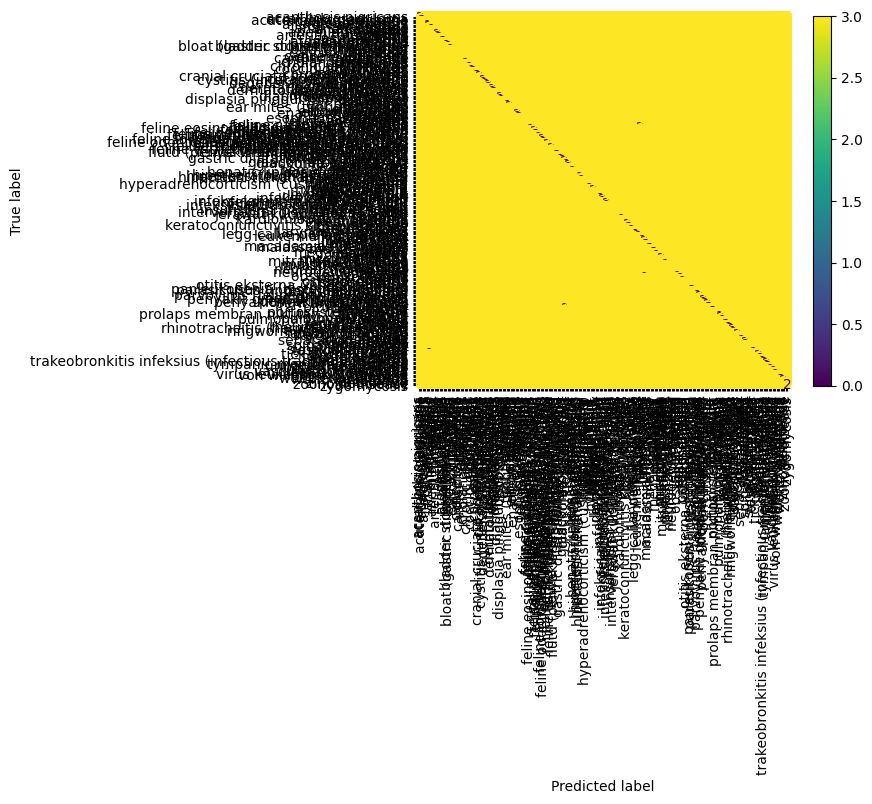

In [18]:
# Evaluate intent model
intent_preds = model_intent.predict(X_intent_test)
intent_preds_labels = np.argmax(intent_preds, axis=1)

print("=== Intent Classification Report ===")
print(classification_report(y_intent_test, intent_preds_labels, target_names=label_encoder.classes_))

# Confusion Matrix for Intent Classification
cm = confusion_matrix(y_intent_test, intent_preds_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
plt.figure(figsize=(20, 20))
disp.plot(xticks_rotation='vertical')
plt.show()

**Membangun Model NER dengan CRF**

Membangun arsitektur model NER dengan layer CRF.

In [19]:
# Build NER model with CRF
from tf2crf import CRF, ModelWithCRFLoss

# Hyperparameters
embedding_dim_ner = 128
lstm_units_ner = 64
dropout_rate_ner = 0.5
num_tags = len(tag2idx)
max_len_ner = X_ner.shape[1]  # Pastikan ini sudah benar

# Membangun arsitektur NER dengan CRF
input_ner = Input(shape=(max_len_ner,), dtype='int32', name='ner_input')
embedding_ner = Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim_ner,
    input_length=max_len_ner,
    mask_zero=True,
    name='ner_embedding'
)(input_ner)

bidirectional_lstm = Bidirectional(
    LSTM(units=lstm_units_ner, return_sequences=True, name='ner_bidirectional_lstm')
)(embedding_ner)

dropout_ner = Dropout(dropout_rate_ner, name='ner_dropout')(bidirectional_lstm)

dense_ner = TimeDistributed(Dense(num_tags, activation=None), name='ner_time_distributed_dense')(dropout_ner)

# Layer CRF dari tf2crf
crf_layer = CRF(num_tags, name='ner_crf')
output_ner = crf_layer(dense_ner)

# Definisikan model dasar
base_model_ner = Model(inputs=input_ner, outputs=output_ner, name='NER_Base_Model_with_CRF')

# Bungkus model dengan ModelWithCRFLoss untuk mengelola loss dan metrics
model_ner = ModelWithCRFLoss(base_model_ner, sparse_target=True)

# Compile model tanpa menentukan loss dan metrics
model_ner.compile(
    optimizer=Adam(learning_rate=0.001)
)

model_ner.build(input_shape=(None, max_len_ner))
# Tampilkan ringkasan model
model_ner.summary()

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Model: "model_with_crf_loss"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 NER_Base_Model_with_CRF (Fu  ((None, 21),             184688    
 nctional)                    (None, 21, 7),                     
                              (None,),                           
                              (7, 7))                            
                                                                 
Total params: 184,692
Trainable params: 184,688
Non-trainable params: 4
_________________________________________________________________


**Melatih Model NER dengan CRF**

Melatih model NER dengan data training dan validasi.

In [20]:
# Callbacks untuk model NER
callbacks_ner = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
]

# Melatih model NER dengan CRF
history_ner = model_ner.fit(
    X_ner_train, y_ner_train,
    validation_data=(X_ner_test, y_ner_test),
    epochs=20,
    batch_size=32,
    callbacks=callbacks_ner
)

Epoch 1/20
51/53 [===========================>..] - ETA: 0s - loss: 12.9550 - accuracy: 0.3572

53/53 [==============================] - 14s 83ms/step - loss: 12.8491 - accuracy: 0.3601 - val_loss_val: 9.1968 - val_val_accuracy: 0.5524 - lr: 0.0010
Epoch 2/20
52/53 [============================>.] - ETA: 0s - loss: 6.4900 - accuracy: 0.6941

53/53 [==============================] - 1s 27ms/step - loss: 6.4396 - accuracy: 0.6943 - val_loss_val: 4.4607 - val_val_accuracy: 0.7706 - lr: 0.0010
Epoch 3/20
53/53 [==============================] - ETA: 0s - loss: 3.2298 - accuracy: 0.8419

53/53 [==============================] - 1s 27ms/step - loss: 3.2298 - accuracy: 0.8419 - val_loss_val: 2.6079 - val_val_accuracy: 0.8750 - lr: 0.0010
Epoch 4/20
51/53 [===========================>..] - ETA: 0s - loss: 1.9004 - accuracy: 0.9209

53/53 [==============================] - 1s 27ms/step - loss: 1.8950 - accuracy: 0.9212 - val_loss_val: 1.5564 - val_val_accuracy: 0.9349 - lr: 0.0010
Epoch 5/20
52/53 [============================>.] - ETA: 0s - loss: 1.2221 - accuracy: 0.9498

53/53 [==============================] - 1s 26ms/step - loss: 1.2039 - accuracy: 0.9498 - val_loss_val: 1.2110 - val_val_accuracy: 0.9522 - lr: 0.0010
Epoch 6/20
52/53 [============================>.] - ETA: 0s - loss: 0.8878 - accuracy: 0.9650

53/53 [==============================] - 1s 25ms/step - loss: 0.9123 - accuracy: 0.9647 - val_loss_val: 0.9829 - val_val_accuracy: 0.9572 - lr: 0.0010
Epoch 7/20
51/53 [===========================>..] - ETA: 0s - loss: 0.6501 - accuracy: 0.9756

53/53 [==============================] - 1s 26ms/step - loss: 0.6392 - accuracy: 0.9757 - val_loss_val: 0.7576 - val_val_accuracy: 0.9683 - lr: 0.0010
Epoch 8/20
52/53 [============================>.] - ETA: 0s - loss: 0.4694 - accuracy: 0.9839

53/53 [==============================] - 1s 27ms/step - loss: 0.4617 - accuracy: 0.9839 - val_loss_val: 0.5955 - val_val_accuracy: 0.9754 - lr: 0.0010
Epoch 9/20
52/53 [============================>.] - ETA: 0s - loss: 0.3565 - accuracy: 0.9883

53/53 [==============================] - 1s 27ms/step - loss: 0.3586 - accuracy: 0.9882 - val_loss_val: 0.4621 - val_val_accuracy: 0.9801 - lr: 0.0010
Epoch 10/20
52/53 [============================>.] - ETA: 0s - loss: 0.2776 - accuracy: 0.9910

53/53 [==============================] - 1s 25ms/step - loss: 0.2783 - accuracy: 0.9910 - val_loss_val: 0.3821 - val_val_accuracy: 0.9842 - lr: 0.0010
Epoch 11/20
52/53 [============================>.] - ETA: 0s - loss: 0.2220 - accuracy: 0.9932

53/53 [==============================] - 1s 25ms/step - loss: 0.2270 - accuracy: 0.9932 - val_loss_val: 0.3479 - val_val_accuracy: 0.9871 - lr: 0.0010
Epoch 12/20
52/53 [============================>.] - ETA: 0s - loss: 0.1764 - accuracy: 0.9946

53/53 [==============================] - 1s 25ms/step - loss: 0.1751 - accuracy: 0.9946 - val_loss_val: 0.2696 - val_val_accuracy: 0.9921 - lr: 0.0010
Epoch 13/20
52/53 [============================>.] - ETA: 0s - loss: 0.1587 - accuracy: 0.9949

53/53 [==============================] - 1s 26ms/step - loss: 0.1561 - accuracy: 0.9949 - val_loss_val: 0.3003 - val_val_accuracy: 0.9889 - lr: 0.0010
Epoch 14/20
51/53 [===========================>..] - ETA: 0s - loss: 0.1319 - accuracy: 0.9963

53/53 [==============================] - 1s 26ms/step - loss: 0.1457 - accuracy: 0.9963 - val_loss_val: 0.2314 - val_val_accuracy: 0.9903 - lr: 0.0010
Epoch 15/20
52/53 [============================>.] - ETA: 0s - loss: 0.1296 - accuracy: 0.9959

53/53 [==============================] - 1s 26ms/step - loss: 0.1291 - accuracy: 0.9959 - val_loss_val: 0.2074 - val_val_accuracy: 0.9918 - lr: 0.0010
Epoch 16/20
52/53 [============================>.] - ETA: 0s - loss: 0.0973 - accuracy: 0.9971

53/53 [==============================] - 1s 28ms/step - loss: 0.0958 - accuracy: 0.9971 - val_loss_val: 0.2243 - val_val_accuracy: 0.9883 - lr: 0.0010
Epoch 17/20
53/53 [==============================] - ETA: 0s - loss: 0.0846 - accuracy: 0.9975

53/53 [==============================] - 2s 28ms/step - loss: 0.0846 - accuracy: 0.9975 - val_loss_val: 0.1445 - val_val_accuracy: 0.9938 - lr: 0.0010
Epoch 18/20
52/53 [============================>.] - ETA: 0s - loss: 0.0675 - accuracy: 0.9983

53/53 [==============================] - 1s 27ms/step - loss: 0.0665 - accuracy: 0.9983 - val_loss_val: 0.1508 - val_val_accuracy: 0.9941 - lr: 0.0010
Epoch 19/20
51/53 [===========================>..] - ETA: 0s - loss: 0.0657 - accuracy: 0.9978

53/53 [==============================] - 1s 27ms/step - loss: 0.0646 - accuracy: 0.9978 - val_loss_val: 0.1480 - val_val_accuracy: 0.9938 - lr: 0.0010
Epoch 20/20
53/53 [==============================] - ETA: 0s - loss: 0.0600 - accuracy: 0.9984

53/53 [==============================] - 1s 27ms/step - loss: 0.0600 - accuracy: 0.9984 - val_loss_val: 0.1315 - val_val_accuracy: 0.9956 - lr: 0.0010


**Evaluasi Model NER**

Menghasilkan laporan klasifikasi dan menghitung metrik precision, recall, dan F1-score untuk model NER.

In [21]:
from seqeval.metrics import precision_score as seqeval_precision
from seqeval.metrics import recall_score as seqeval_recall
from seqeval.metrics import f1_score as seqeval_f1
from seqeval.metrics import classification_report as seqeval_classification_report

def sequences_to_tags(sequences, idx2tag):
    """Converts sequences of tag indices to sequences of tag labels."""
    result = []
    # Jika input adalah array satu dimensi, bungkus menjadi list of list
    if isinstance(sequences, np.ndarray) and sequences.ndim == 1:
        sequences = [sequences]

    for sequence in sequences:
        tag_sequence = [idx2tag.get(int(idx), 'O') for idx in sequence]  # Pastikan idx dikonversi ke int
        result.append(tag_sequence)
    return result

# Menghasilkan prediksi NER pada data uji
ner_preds = model_ner.predict(X_ner_test)

# Tidak perlu menggunakan argmax karena CRF sudah memberikan indeks tag secara langsung
ner_preds_labels = ner_preds

# Mengonversi y_ner_test dan prediksi menjadi tag NER
y_ner_test_tags = sequences_to_tags(y_ner_test, idx2tag)
ner_preds_tags = sequences_to_tags(ner_preds_labels, idx2tag)

# Menghapus padding dari prediksi
def remove_padding(tags, tokens):
    clean_tags = []
    for tag_seq, token_seq in zip(tags, tokens):
        clean_tag_seq = [tag for tag, token in zip(tag_seq, token_seq) if token != 0]  # Hapus tag saat token adalah padding
        clean_tags.append(clean_tag_seq)
    return clean_tags

# Menghapus padding dari y_ner_test_tags dan ner_preds_tags
filtered_y_ner_test_tags_clean = remove_padding(y_ner_test_tags, X_ner_test)
filtered_ner_preds_tags_clean = remove_padding(ner_preds_tags, X_ner_test)

# Validasi jumlah sampel setelah filter
print("Filtered number of samples in y_ner_test_tags_clean:", len(filtered_y_ner_test_tags_clean))
print("Filtered number of samples in ner_preds_tags_clean:", len(filtered_ner_preds_tags_clean))

# Laporan Klasifikasi setelah memfilter
if len(filtered_y_ner_test_tags_clean) > 0 and len(filtered_ner_preds_tags_clean) > 0:
    print("=== NER Classification Report (Filtered) ===")
    print(seqeval_classification_report(filtered_y_ner_test_tags_clean, filtered_ner_preds_tags_clean))

    # Menggunakan seqeval untuk menghitung metrics tambahan
    print("NER Precision (seqeval): {:.4f}".format(seqeval_precision(filtered_y_ner_test_tags_clean, filtered_ner_preds_tags_clean)))
    print("NER Recall (seqeval): {:.4f}".format(seqeval_recall(filtered_y_ner_test_tags_clean, filtered_ner_preds_tags_clean)))
    print("NER F1-Score (seqeval): {:.4f}".format(seqeval_f1(filtered_y_ner_test_tags_clean, filtered_ner_preds_tags_clean)))
else:
    print("Tidak ada sampel yang valid setelah filtering.")

14/14 [==============================] - 3s 8ms/step
Filtered number of samples in y_ner_test_tags_clean: 418
Filtered number of samples in ner_preds_tags_clean: 418
=== NER Classification Report (Filtered) ===
              precision    recall  f1-score   support

      animal       0.99      1.00      0.99       359
   condition       0.97      0.95      0.96        96
     symptom       1.00      1.00      1.00       813

   micro avg       0.99      0.99      0.99      1268
   macro avg       0.98      0.98      0.98      1268
weighted avg       0.99      0.99      0.99      1268

NER Precision (seqeval): 0.9906
NER Recall (seqeval): 0.9945
NER F1-Score (seqeval): 0.9925


## `**Test Model**`

**Mendefinisikan Fungsi Prediksi Intent dan Entitas**

Membuat fungsi untuk memprediksi intent dan entitas berdasarkan input pengguna.

In [22]:
# Function to predict intent
def predict_intent(text):
    preprocessed_text = preprocess_text(text)
    seq = tokenizer.texts_to_sequences([preprocessed_text])
    seq_padded = pad_sequences(seq, maxlen=max_len, padding='post')
    pred = model_intent.predict(seq_padded)
    intent_idx = np.argmax(pred, axis=1)[0]
    intent = label_encoder.inverse_transform([intent_idx])[0]
    return intent

# Function to predict entities
def predict_entities(text):
    preprocessed_text = preprocess_text(text)
    tokens = nltk.word_tokenize(preprocessed_text)
    seq = tokenizer.texts_to_sequences([preprocessed_text])
    seq_padded = pad_sequences(seq, maxlen=max_len_ner, padding='post')
    pred = model_ner.predict(seq_padded)

    ner_preds_labels = pred[0]
    pred_tags = sequences_to_tags(ner_preds_labels, idx2tag)

    # Menghapus padding
    pred_tags_clean = []
    for tag_seq, token_seq in zip(pred_tags, [tokens]):
        clean_tag_seq = [tag for tag, token in zip(tag_seq, token_seq) if token != '<OOV>' and token != '']
        pred_tags_clean.append(clean_tag_seq)

    entities = []
    for token, tag in zip(tokens, pred_tags_clean[0]):
        if tag != 'O':
            entities.append((token, tag))
    return entities

**Mendefinisikan Fungsi Respon Chatbot**

Membuat fungsi untuk memberikan respon chatbot berdasarkan intent dan entitas yang diprediksi.

In [23]:
def get_chatbot_response(user_input):
    # Predict intent
    intent = predict_intent(user_input)
    # Predict entities
    entities = predict_entities(user_input)
    entities_dict = {}
    for token, tag in entities:
        label = tag.split('-')[-1]
        if label in entities_dict:
            entities_dict[label].append(token)
        else:
            entities_dict[label] = [token]

    # Find the appropriate response
    intent_data_list = intent_data.get("intents", [])
    intent_data_item = next((item for item in intent_data_list if "conditions" in item and item["conditions"][0].lower() == intent), None)

    if intent_data_item:
        response = intent_data_item.get("responses", ["Maaf, tidak ada saran yang tersedia."])
        response_text = f"Hewan Anda mengalami penyakit {intent}. Lakukan langkah berikut: {response[0]}."
        if 'symptom' in entities_dict:
            symptoms = ', '.join(entities_dict.get('symptom', []))
            response_text += f" Gejala yang terdeteksi: {symptoms}."
        if 'animal' in entities_dict:
            animal = ', '.join(entities_dict.get('animal', []))
            # response_text += f" Hewan: {animal}."
        return response_text
    else:
        return "Maaf, saya tidak mengerti. Bisa dijelaskan lebih lanjut?"

**Menguji Chatbot dengan Contoh Input**

Menguji chatbot dengan beberapa input pengguna untuk memastikan bahwa responnya sesuai.

In [26]:
# Testing the chatbot
user_inputs = [
    "Kucing saya mengalami mata berair, bersin, batuk. Apakah ini infestasi kutu?",
    "Kucing saya mengalami lesi kulit, gatql, bulu rontok",
    "Kucing saya mengalami bengkak pada perut, muntah",
    "Anjing mengalami Kulit gatal, Merah, Rontok, Luka terbuka"
]

for user_input in user_inputs:
    response = get_chatbot_response(user_input)
    print(f"User: {user_input}")
    print(f"Chatbot: {response}\n")

1/1 [==============================] - 0s 27ms/step
User: Kucing saya mengalami mata berair, bersin, batuk. Apakah ini infestasi kutu?
Chatbot: Hewan Anda mengalami penyakit canine influenza. Lakukan langkah berikut: Isolasi hewan yang terinfeksi, Terapi suportif, Berikan antibiotik untuk infeksi sekunder, Cairan IV jika diperlukan.. Gejala yang terdeteksi: mata, air, bersin.

1/1 [==============================] - 0s 27ms/step
User: Kucing saya mengalami lesi kulit, gatql, bulu rontok
Chatbot: Hewan Anda mengalami penyakit infeksi jamur (fungal infection). Lakukan langkah berikut: Pemberian antijamur topikal atau oral seperti itraconazole, menjaga kebersihan lingkungan, dan perawatan suportif.. Gejala yang terdeteksi: lesi, kulit, gatql.

1/1 [==============================] - 0s 30ms/step
User: Kucing saya mengalami bengkak pada perut, muntah
Chatbot: Hewan Anda mengalami penyakit yersiniosis. Lakukan langkah berikut: Pemberian antibiotik spektrum luas seperti ciprofloxacin, terapi c

**Menyimpan Tokenizer dan Label Encoder**

In [27]:
# Simpan tokenizer dan label encoder
import os

if not os.path.exists('models'):
    os.makedirs('models')

tokenizer_json = tokenizer.to_json()
with open('models/tokenizer.json', 'w', encoding='utf-8') as f:
    json.dump(tokenizer_json, f, ensure_ascii=False, indent=4)

# Menyimpan Label Encoder
with open('models/label_encoder.json', 'w', encoding='utf-8') as f:
    json.dump(label_encoder.classes_.tolist(), f, ensure_ascii=False, indent=4)

# Menyimpan tag2idx dan idx2tag
with open('models/tag2idx.json', 'w', encoding='utf-8') as f:
    json.dump(tag2idx, f, ensure_ascii=False, indent=4)

with open('models/idx2tag.json', 'w', encoding='utf-8') as f:
    json.dump(idx2tag, f, ensure_ascii=False, indent=4)

**Menyimpan Model Intent dan NER**

In [28]:
# Menyimpan model Intent
model_intent.save('models/model_intent')

# Menyimpan model NER dengan CRF
model_ner.save('models/model_ner_with_crf')